In [1]:
clear all

In [2]:
!pip install polars

  Using cached polars-1.3.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached polars-1.3.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)


In [3]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)


In [4]:
!pip install pytorchtools

  Using cached pytorchtools-0.0.2-py2.py3-none-any.whl.metadata (2.2 kB)
Using cached pytorchtools-0.0.2-py2.py3-none-any.whl (3.1 kB)


In [5]:
import polars as pl
import cv2
import glob
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import Module
from torchvision import models, io
import torch.nn.functional as F
from datetime import datetime
import os
from tqdm import tqdm
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity

In [6]:
dfs=[pl.read_csv(filename) for filename in glob.glob('/home/jovyan/my_work/Egypto/dfs/dfs/df_*.csv')]
df=pl.concat(dfs)
df.head()

filenames,classes,bb
str,str,str
"""drive/MyDrive/cropped_pictures…","""""",""""""
"""drive/MyDrive/cropped_pictures…","""2""","""72.0,37.0,236.23839330673218,1…"
"""drive/MyDrive/cropped_pictures…","""""",""""""
"""drive/MyDrive/cropped_pictures…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""drive/MyDrive/cropped_pictures…","""""",""""""


In [7]:
df=df.with_columns(pl.col('filenames').str.split('/').list.last())
df.head()

filenames,classes,bb
str,str,str
"""425942001_300_300_243_543_empt…","""""",""""""
"""425942001_300_300_243_543_cara…","""2""","""72.0,37.0,236.23839330673218,1…"
"""420886001_300_300_1028_1328_em…","""""",""""""
"""420886001_300_300_1028_1328_ca…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""423879001_300_300_814_1114_emp…","""""",""""""


In [8]:
all_images=os.listdir('/home/jovyan/my_work/Egypto/Images')
existing_files_series = pl.Series(all_images)


In [9]:
df=df.with_columns(pl.col('filenames').is_in(all_images).alias('new_image')).filter(pl.col('new_image'))

In [10]:
df=df.drop('new_image')
df.head()

filenames,classes,bb
str,str,str
"""425942001_300_300_243_543_empt…","""""",""""""
"""425942001_300_300_243_543_cara…","""2""","""72.0,37.0,236.23839330673218,1…"
"""420886001_300_300_1028_1328_em…","""""",""""""
"""420886001_300_300_1028_1328_ca…","""0""","""0.0,0.0,225.8830212788887,409.…"
"""423879001_300_300_814_1114_emp…","""""",""""""


We're checkin for duplicates

In [69]:
df['filenames'][1]

'432546001_1200_300_1001_1301_caractere.png'

In [ ]:
df['filenames'].value_counts(

).filter(pl.col('count')>1
         ).with_columns(pl.col('filenames').str.split('_').list.last().str.split('.').list.first().alias('caractere_or_empty')
         ).filter(pl.col('caractere_or_empty')=='caractere').shape

(103, 3)

droping the duplicates and keeping the last one ( since the photos were probably overwritten because they were assigned the same same )

In [11]:
df=df.unique(subset='filenames', keep='last')

## Customization du dataset [link here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [17]:
class CustomDataset(Dataset):
  """
  This Class creates tensor for each value in a dataframe.
  """
  def __init__(self, df, transform:bool):
    """
      df: dataframe with the annotations
    root_dir: directory with all the images
    transform: Optionnal transform to apply
    """

    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    # On rajoute le transform, voir ce que ça fait sur les résultats
    img_name=self.df['filenames'][idx]
    image_file=os.path.join('/home/jovyan/my_work/Egypto/Images',img_name)
    image=cv2.imread(image_file)
    image=1.6*image - 50
    image=image/255

    if image is None:
      raise FileNotFoundError(f"Image {img_name} not found")
    if self.transform:
      image=self.transform(image)
      #On verrifie que 'bb' et 'classes' sont non vides sinon ca risque de buguer
    if image is not None:
      image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
    bb_str=self.df['bb'][idx]
    if bb_str:
      bb=list(map(float,self.df['bb'][idx].split(',')))
      target=torch.tensor(bb,dtype=torch.float32)
    else:
      target=torch.tensor([0,0,300,300], dtype=torch.float32)
    classe_str=self.df['classes'][idx]
    label_map = {'0': 0, '1': 1, '2': 2, '':3}
    label = torch.tensor(label_map.get(classe_str, -1), dtype=torch.float32)
#     else:
#       label = torch.tensor(3, dtype=torch.float32)

    return image, target, label


In [18]:
def custom_collate_fn(batch):
  """
  This function collates the tensor for them to have the same size

  batch: batch in the dataloader
  """
  images, targets, labels = zip(*batch)

    # Convert images from numpy arrays to torch tensors if needed
  images = [torch.tensor(image) if isinstance(image, np.ndarray) else image for image in images]
  images = torch.stack(images, 0)
  bbox= [torch.tensor(t) if isinstance(t, np.ndarray) else t for t in targets]
  bbox_stacked=torch.stack(bbox,0)
  cls= [torch.tensor(c) if isinstance(c, np.ndarray) else c for c in labels]
  cls_stacked=torch.stack(cls,0)

  return images, bbox_stacked, labels

In [19]:
train, test= train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['classes'])

In [20]:
dataset_train=CustomDataset(train, transform=False )
dataset_test=CustomDataset(test, transform=False)
dataloader_train=DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)
dataloader_test=DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)

In [21]:
class VGG16(nn.Module):
  def __init__(self, num_classes=4, num_bbox_coords=4):
    super(VGG16, self).__init__()
    self.layer1= nn.Sequential(nn.Conv2d(3,64, (3,3)),
                               nn.BatchNorm2d(64),
                               nn.ReLU())
    self.layer2=nn.Sequential(nn.Conv2d(64,64, (3,3)),
                              nn.BatchNorm2d(64),
                              nn.ReLU(),
                              nn.MaxPool2d((2,2), stride=2))
    self.layer3= nn.Sequential(nn.Conv2d(64,128, (3,3)),
                               nn.BatchNorm2d(128),
                               nn.ReLU())
    self.layer4= nn.Sequential(nn.Conv2d(128,128,(3,3)),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2), stride=2))
    self.layer5= nn.Sequential(nn.Conv2d(128,256,(3,3)),
                               nn.BatchNorm2d(256),
                               nn.ReLU())
    self.layer6=nn.Sequential(nn.Conv2d(256,256, (3,3)),
                              nn.BatchNorm2d(256),
                              nn.ReLU())
    self.layer7=nn.Sequential(nn.Conv2d(256,256, (3,3)),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.MaxPool2d((2,2), stride=2, ceil_mode=True))
    self.layer8=nn.Sequential(nn.Conv2d(256,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU())
    self.layer9=nn.Sequential(nn.Conv2d(512,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                             nn.MaxPool2d((2,2),stride=2))
    self.layer10=nn.Sequential(nn.Conv2d(512,512, (3,3)),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                               nn.MaxPool2d((2,2), stride=2))
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc=nn.Sequential(nn.Dropout(0.6),
                          nn.Linear(512, 4096),
                          nn.ReLU())
    self.fc1=nn.Sequential(nn.Dropout(0.6),
                           nn.Linear(4096, 4096),
                           nn.ReLU())
    self.fc_bbox=nn.Linear(4096,num_bbox_coords)
    self.fc_class=nn.Linear(4096, num_classes)



  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=self.layer3(out)
    out=self.layer4(out)
    out=self.layer5(out)
    out=self.layer6(out)
    out=self.layer7(out)
    out=self.layer8(out)
    out=self.layer9(out)
    out=self.layer10(out)
    out=self.global_avg_pool(out)
    out=out.view(out.size(0), -1)
    out=self.fc(out)
    out=self.fc1(out)
    out_bbox=self.fc_bbox(out)
    out_class=self.fc_class(out)
    return out_bbox, out_class

labels=['class0', 'class1', 'class2', 'empty']
module=VGG16(num_classes=len(labels)).to("cuda")
#summary(module, input_size=(3,300,300))

In [22]:
pretrained_dict=torch.load('module.pt')
model_dict=module.state_dict()

In [28]:
pretrained_dict={k: v for k,v in pretrained_dict.items() if k in model_dict and 'fc_class' not in k}

In [29]:
model_dict.update(pretrained_dict)
module.load_state_dict(model_dict)

<All keys matched successfully>

In [32]:
class EarlyStopping:
    def __init__(self,patience=3, verbose=False, delta=0):
        self.patience=patience
        self.verbose=verbose
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf
        self.delta=delta
    
    def __call__(self,val_loss,model):
        score=-val_loss
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score + self.delta:
            self.counter+=1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0
            

# On prend la même loss et le même optimizer qu'ici

In [33]:
loss_fn=torch.nn.CrossEntropyLoss()

In [34]:

optimizer=torch.optim.Adam(module.parameters(),lr=0.001, weight_decay=1e-4)

In [35]:
import torch.nn.functional as F

def custom_loss_fn(bbox_outputs, class_outputs, bbox_targets, class_number):
    bbox_targets = torch.stack([b for b in bbox_targets])
    if class_outputs.dtype != torch.float:
      class_outputs = class_outputs.float()
    bbox_loss = F.smooth_l1_loss(bbox_outputs, bbox_targets, reduction='mean')
    class_loss = loss_fn(class_outputs, class_number)
    total_loss = bbox_loss + class_loss
    return total_loss, bbox_loss, class_loss


In [36]:
def train_one_epoch(epoch_index, tb_writer,total_correct, total_samples):
    temperature=2
    running_loss = 0
    last_loss = 0

    for i, (image, bbox, classe) in enumerate(dataloader_train):
        inputs=image.to("cuda")
        #Corriger liste de tensors
        bbox_targets = [b.to("cuda") for b in bbox]
        #Classe_target doit être un torch.long pour crossentropy
        classe=np.asarray(classe)
        class_targets=torch.tensor(classe,dtype=torch.int64).to("cuda")
        
        bbox_outputs, class_outputs = module(inputs)
        class_outputs=temperature*class_outputs
        _,predictions=torch.max(class_outputs,1)
        total_correct+=(predictions==class_targets).sum().item()
        total_samples+=class_targets.size(0)
        loss, bbox_loss, class_loss = custom_loss_fn(bbox_outputs, class_outputs, bbox_targets, class_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(dataloader_train) + i + 1
            running_loss = 0
            accuracy=100*total_correct/total_samples
            distance=bbox_targets[-1]-bbox_outputs[-1]
            print('distance:',distance)
            print('batch{} acc: {}'.format(i+1, accuracy))
            print(bbox_loss, class_loss)
    return last_loss


In [37]:
early_stopping=EarlyStopping()
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
log_file='log_trains_1'
#os.makedirs(log_file)
writer=SummaryWriter(log_file.format(timestamp))
epoch_number=0
EPOCHS=5
best_v_loss=1
for epoch in tqdm(range(EPOCHS)):
  total_correct=0
  total_samples=0
  total_v_correct=0
  total_v_samples=0    
  print('EPOCH{}'.format(epoch_number + 1))
  module.train(True)
  torch.cuda.empty_cache()
  avg_loss=train_one_epoch(epoch_number,writer, total_correct, total_samples)
  torch.cuda.empty_cache()
  running_vloss=0
  module.eval()
  with torch.no_grad():
      
    for i,(vimages, vbbox, vclass) in enumerate(dataloader_test):
      vinputs= vimages.to("cuda")
      vbbox_target=[b.to("cuda") for b in vbbox]
      vclass_targets=np.asarray(vclass)
      vclass_target=torch.tensor(vclass_targets, dtype=torch.int64).to("cuda")
      voutputs_bbox, voutputs_class=module(vinputs)
      _,v_predictions=torch.max(voutputs_class,1)
      total_v_correct+=(v_predictions==vclass_target).sum().item()
      total_v_samples+=vclass_target.size(0)
      vloss, vbbox_loss, vclasse_loss =custom_loss_fn(voutputs_bbox, voutputs_class, vbbox_target, vclass_target)
      running_vloss+=vloss
 
  v_accuracy=100*total_v_correct/total_v_samples
  print(f'validation acc: {v_accuracy}')
  avg_vloss=running_vloss/(i+1)
  print('LOSS train {} valid {}'.format(avg_loss, avg_vloss ))
  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
  writer.flush()
  early_stopping(avg_vloss, module)
    # Track best performance, and save the model's state
  if avg_vloss < best_v_loss:
      best_vloss = avg_vloss
      model_path = 'model_{}_{}'.format(timestamp, epoch_number)
      torch.save(module.state_dict(), model_path)

  epoch_number += 1

2024-08-01 09:41:13.418517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH1
batch 1000 loss: 9.581605561733246
distance: tensor([1.2437, 7.4202, 7.3311, 3.8986], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 95.8375
tensor(6.6805, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
batch 2000 loss: 7.091786715984345
distance: tensor([-9.4260, -0.8979,  2.7107, 13.8170], device='cuda:0',
       grad_fn=<SubBackward0>)
batch2000 acc: 96.875
tensor(12.5188, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.2527, device='cuda:0', grad_fn=<NllLossBackward0>)



 20%|██        | 1/5 [07:47<31:08, 467.12s/it]

validation acc: 96.1261436636169
LOSS train 7.091786715984345 valid 7.2793402671813965
EPOCH2
batch 1000 loss: 6.007185663938523
distance: tensor([ 2.7449,  1.6928, -3.9537, -3.0894], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 98.8
tensor(6.5189, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
batch 2000 loss: 5.922279857397079
distance: tensor([18.6078,  2.2571,  4.0426, -1.0218], device='cuda:0',
       grad_fn=<SubBackward0>)
batch2000 acc: 98.728125
tensor(5.8996, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward0>)



 40%|████      | 2/5 [15:23<23:03, 461.08s/it]

validation acc: 99.47440140159627
LOSS train 5.922279857397079 valid 3.238645076751709
EPOCH3
batch 1000 loss: 5.5799112892150875
distance: tensor([-0.5692,  1.8535, -0.0149, -3.7351], device='cuda:0',
       grad_fn=<SubBackward0>)
batch1000 acc: 99.0375
tensor(3.8072, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(8.1956e-08, device='cuda:0', grad_fn=<NllLossBackward0>)
batch 2000 loss: 5.47603850364685
distance: tensor([-9.1912, -2.1166, -4.3637,  1.0832], device='cuda:0',
       grad_fn=<SubBackward0>)
batch2000 acc: 99.071875
tensor(6.0427, device='cuda:0', grad_fn=<SmoothL1LossBackward0>) tensor(1.4901e-08, device='cuda:0', grad_fn=<NllLossBackward0>)



 60%|██████    | 3/5 [23:02<15:20, 460.14s/it]

validation acc: 99.69826747128674
LOSS train 5.47603850364685 valid 2.606903076171875
EPOCH4


 60%|██████    | 3/5 [23:49<15:53, 476.52s/it]


KeyboardInterrupt: 

In [45]:
module.state_dict()
torch.save(module.state_dict(), 'module_with_all_classes.pt')

### The model performs pretty well

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([  2.0185,   0.8903, 303.3934, 303.5100], device='cuda:0') tensor([ 1.5964, -6.4396, -8.4500, 26.0095], device='cuda:0') tensor(3.)


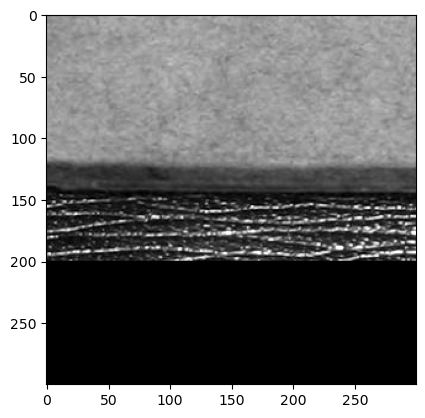

In [44]:
with torch.no_grad():
    for images, bb, cls in dataloader_test:
        inputs=images.to("cuda")
        bbox_outputs, clas_outputs=module(inputs)
        img=images[0].permute(1,2,0)
        plt.imshow(img)
        print(bbox_outputs[0], clas_outputs[0], cls[0])
        break